# 3––Time Series Classification

* Univariate
* Multivariate

---
## Univariate time series classification

In forecasting, we're interested in using past data to make temporal forward predictions. sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.

<img src="../images/time-series-classification.png" width=1000/>


### The basic workflow

1. Specify data
1. Specify task: Which variable is the target variable, which ones are features?
1. Specify model
1. Fit
1. Predict

#### Data

To find other datasets, go to: http://timeseriesclassification.com/dataset.php

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X, y = load_UCR_UEA_dataset("ItalyPowerDemand", return_X_y=True)
X = convert(X, from_type="nested_univ", to_type="numpy3D")

In [2]:
# multi-class target variable
np.unique(y)

array(['1', '2'], dtype=object)

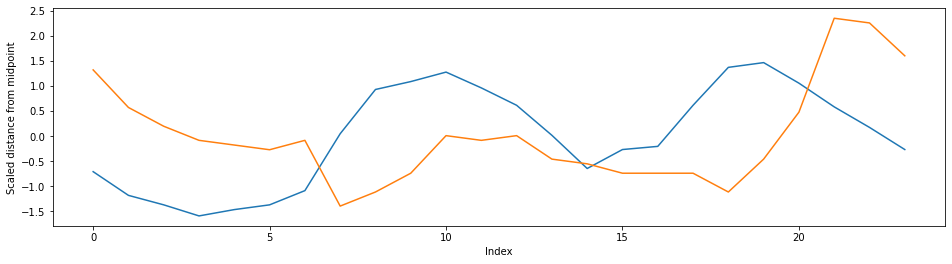

In [3]:
labels, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    ax.plot(X[y == label, 0, :][0], label=f"class {label}")
ax.set(ylabel="Scaled distance from midpoint", xlabel="Index");

#### Train-test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Model specification

In [5]:
from sktime.classification.kernel_based import ROCKETClassifier

classifier = ROCKETClassifier()

#### Fitting

In [6]:
classifier.fit(X_train, y_train)

ROCKETClassifier()

In [7]:
classifier.fit?

Signature: classifier.fit(X, y)
Docstring:
Fit time series classifier to training data.

Parameters
----------
X : 2D np.array (univariate, equal length series) of shape = [n_instances,
series_length]
    or 3D np.array (any number of dimensions, equal length series) of shape =
    [n_instances,n_dimensions,series_length]
    or pd.DataFrame with each column a dimension, each cell a pd.Series (any
    number of dimensions, equal or unequal length series)
y : 1D np.array of shape =  [n_instances] - the class labels.

Returns
-------
self :
    Reference to self.

Notes
-----
Changes state by creating a fitted model that updates attributes
ending in "_" and sets is_fitted flag to True.
File:      ~/Documents/Research/software/sktime/sktime/sktime/classification/base.py
Type:      method


#### Prediction

In [8]:
y_pred = classifier.predict(X_test)

#### Evaluation

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9635036496350365

### Another example

In [10]:
from sktime.classification.feature_based import TSFreshClassifier

In [11]:
classifier = TSFreshClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9635036496350365

### State-of-the-art time series classifier
Check out the research paper: https://link.springer.com/article/10.1007%2Fs10994-021-06057-9

In [12]:
# from sktime.classification.hybrid import HIVECOTEV2

# X_train, y_train = load_UCR_UEA_dataset("BasicMotions", split="train", return_X_y=True)
# X_test, y_test = load_UCR_UEA_dataset("BasicMotions", split="test", return_X_y=True)

# classifier = HIVECOTEV2()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

#### Classifiers in sktime

In [13]:
from sktime.registry import all_estimators

all_estimators("classifier", return_names=False)

Importing plotly failed. Interactive plots will not work.


[sktime.classification.kernel_based._arsenal.Arsenal,
 sktime.classification.dictionary_based._boss.BOSSEnsemble,
 sktime.classification.interval_based._cif.CanonicalIntervalForest,
 sktime.classification.feature_based._catch22_classifier.Catch22Classifier,
 sktime.classification.hybrid._catch22_forest_classifier.Catch22ForestClassifier,
 sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier,
 sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier,
 sktime.classification.dictionary_based._cboss.ContractableBOSS,
 sktime.classification.interval_based._drcif.DrCIF,
 sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble,
 sktime.classification.hybrid._hivecote_v1.HIVECOTEV1,
 sktime.classification.hybrid._hivecote_v2.HIVECOTEV2,
 sktime.classification.dictionary_based._boss.IndividualBOSS,
 sktime.classification.dictionary_based._tde.IndividualTDE,
 sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClas

### But can I not just use scikit-learn?

In principle, yes, but may not be as powerful as dedicated time series classification algorithms ...

See our previous tutorial from the PyData Amsterdam 2020 for more details: https://github.com/sktime/sktime-tutorial-pydata-amsterdam-2020
 
**Compare algorithms from sktime and scikit-learn!**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier = make_pipeline(
    Tabularizer(), KNeighborsClassifier(n_neighbors=1, metric="euclidean")
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.948905109489051

### Advanced model building & composition

#### Tuning

#### Pipelining

Check out the tsfresh package for automatic feature extraction: https://tsfresh.readthedocs.io/en/latest/

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [16]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(disable_progressbar=True, show_warnings=False),
    RandomForestClassifier(),
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9598540145985401

---
## Interlude: Time series regression

### Basic workflow

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import load_benzene_concentration_sample

Find out more about the dataset here: https://zenodo.org/record/3902673#.YXqxNy8w3UI

In [18]:
X, y = load_benzene_concentration_sample()
print(X.shape, y.shape)

(300, 1, 240) (300,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

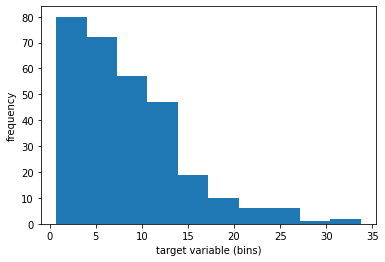

In [20]:
fig, ax = plt.subplots(1)
ax.hist(y)
ax.set(xlabel="target variable (bins)", ylabel="frequency");

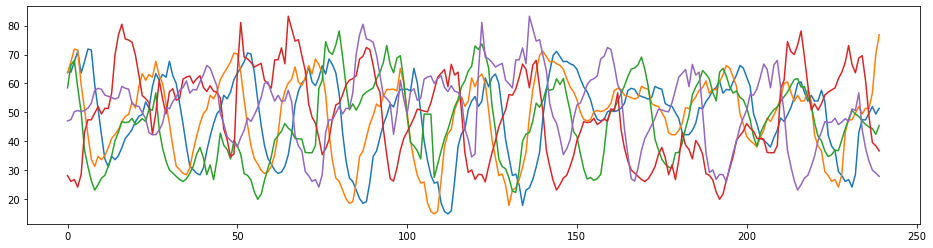

In [21]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for i in range(5):
    ax.plot(X_train[i, 0, :])

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

In [23]:
regressor = make_pipeline(Rocket(), RandomForestRegressor())
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

15.889726613206516

### Reducing forecasting to time series regression
<img src="../images/forecasting-to-regression-reduction.png" width=500 align=right />

In [24]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

y = load_airline()
fh = np.arange(12) + 1
y_train, y_test = temporal_train_test_split(y, fh=fh)

In [25]:
forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)

Look up the term "scitype" in our glossary: https://www.sktime.org/en/stable/glossary.html#term-Scientific-type

In [26]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender

pipe = TransformedTargetForecaster([("detrend", Detrender()), ("forecast", forecaster)])

pipe.fit(y_train)
y_pred = pipe.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

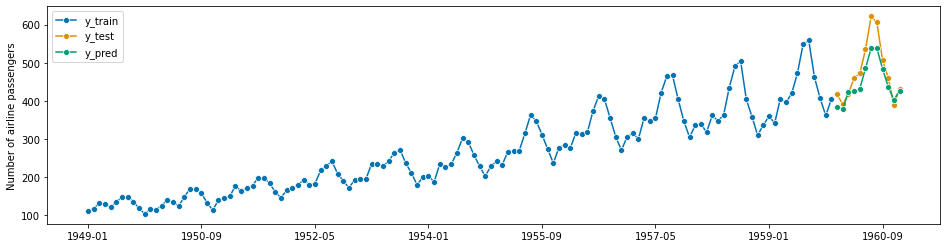

In [27]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

---
## Multivariate time series classification

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator

### Load multivariate time series/panel data

The [data set](http://www.timeseriesclassification.com/description.php?Dataset=BasicMotions) we use in this notebook was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [29]:
X, y = load_UCR_UEA_dataset("BasicMotions", return_X_y=True)
X = convert(X, from_type="nested_univ", to_type="numpy3D")

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 6, 100) (60,) (20, 6, 100) (20,)


In [30]:
# multi-class target variable
np.unique(y_train)

array(['badminton', 'running', 'standing', 'walking'], dtype=object)

## Multivariate classification
`sktime` offers three main ways of solving multivariate time series classification problems:

1. _Concatenation_ of time series columns into a single long time series column via `ColumnConcatenator` and apply a classifier to the concatenated data,
2. _Column-wise ensembling_ via `ColumnEnsembleClassifier` in which one classifier is fitted for each time series column and their predictions aggregated,
3. _Bespoke estimator-specific methods_ for handling multivariate time series data, e.g. finding shapelets in multidimensional spaces (still work in progress).

### Time series concatenation
We can concatenate multivariate time series/panel data into long univiariate time series/panel and then apply a classifier to the univariate data.

In [31]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
classifier = Pipeline(steps)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

1.0

### Column ensembling
We can also fit one classifier for each time series column and then aggregated their predictions. The interface is similar to the familiar `ColumnTransformer` from sklearn.

In [32]:
classifier = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=10), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.85

### Bespoke classification algorithms
Another approach is to use bespoke (or classifier-specific) methods for multivariate time series data. Here, we try out the HIVE-COTE (version 2) algorithm  in multidimensional space.

In [33]:
# classifier = HIVECOTEV2()
# classifier.fit(X_train, y_train)
# classifier.score(X_test, y_test)

---
## Building your own classifier

Check out our [classifier extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/classification.py)!

This is a Python file with to-do code blocks that allow you to implement your own, sktime-compatible classification algorithm.


---
## Summary

* univariate time series classification
* time series regression
* reduction: using time series regression for forecasting
* multivariate time series classification

### Useful resources

#### Research and benchmarking
* For time-series classification data sets and Java-based methods, check out [timeseriesclassification.com](http://www.timeseriesclassification.com)
* For a comparative benchmarking studies, check out 
    * [Bagnall, Anthony, et al. "The great time series classification bake off: a review and experimental evaluation of recent algorithmic advances." Data Mining and Knowledge Discovery 31.3 (2017): 606-660.](https://www.researchgate.net/profile/Anthony_Bagnall/publication/301856632_The_Great_Time_Series_Classification_Bake_Off_An_Experimental_Evaluation_of_Recently_Proposed_Algorithms_Extended_Version/links/579b580e08ae80bf6ea33d12.pdf) and 
    * [Fawaz, Hassan Ismail, et al. "Deep learning for time series classification: a review." Data Mining and Knowledge Discovery 33.4 (2019): 917-963.](https://arxiv.org/pdf/1809.04356)

#### Deep learning 
* For deep-learning, check out sktime's companion packages: [sktime-dl](https://github.com/sktime/sktime-dl)